# Lab 2

**Lecture**: Deep Learning (Prof. Dr. David Rügamer, Emanuel Sommer)

## Imports

In [3]:
import torch
from torch import Tensor

import matplotlib.pyplot as plt
from  matplotlib_inline.backend_inline import set_matplotlib_formats
import seaborn as sns
set_matplotlib_formats('png', 'pdf')
sns.set_style('darkgrid')

## Exercise 1
Consider a neural network with one hidden layer with threshold activation function
(i.e., $\tau(x)=\textbf{1}[x>0]$) and one output neuron with no activation function.
Prove that such a neural network cannot _exactly_ separate the cyan ($y=1$) and white
($y=0$) areas in the figure below.

![A region that cannot be classified correctly by a neural network
with a single hidden layer.](../utils/02-lab-f1.png)

**Hint**: start by assuming that such a neural network exists and has two neurons in the
 hidden layer with a generic activation function $\tau(\cdot)$. Consider four points, one for each of the four regions,
 $\textbf{x}_1,\ldots,\textbf{x}_4$ with $y_2=y_4=0$ and $y_1=y_3=1$.
 Compute the difference between the predictions of points with different labels,
 $g(\textbf{x}_1)-g(\textbf{x}_2)$ and $g(\textbf{x}_4)-g(\textbf{x}_3)$.
 You should reach a contradiction, meaning that such a neural network does not exists.


<!-- #region pycharm={"name": "#%% md\n"} -->
## Exercise 2

In this exercise, we are going to create a neural network with two hidden layers and
threshold activation that can correctly separate the cyan region from the rest in the
plot below. We will do this by composing linear classifiers just like we did in the
previous lab.

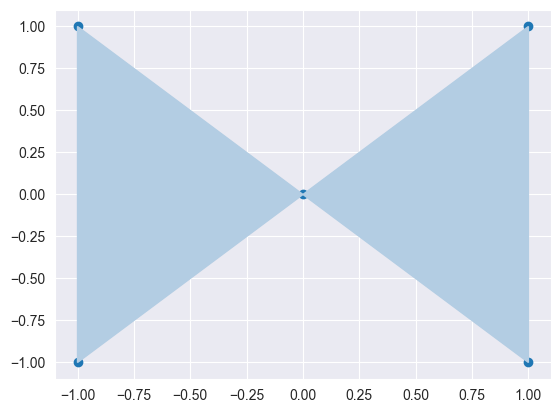

In [4]:
dots = torch.tensor([[-1, 1], [-1, -1], [0, 0], [1, 1], [1, -1]])
plt.figure()
plt.scatter(dots[:, 0], dots[:, 1])
t1 = plt.Polygon([[-1, 1], [-1, -1], [0, 0]], color='#b3cde3')
plt.gca().add_patch(t1)

t2 = plt.Polygon(dots[2:5,:], color='#b3cde3')
plt.gca().add_patch(t2)
plt.show()

Let us create a dataset containing points on a grid to test the network:

In [5]:
# Build a grid of equally-spaced points, plus a column for the bias
grid_range = torch.linspace(-2, 2, 50)
grid_x, grid_y = torch.meshgrid(grid_range, grid_range, indexing='ij')
data = torch.stack([torch.ones(50**2), grid_x.flatten(), grid_y.flatten()]).T

print(data.shape)
print(data[:10])

torch.Size([2500, 3])
tensor([[ 1.0000, -2.0000, -2.0000],
        [ 1.0000, -2.0000, -1.9184],
        [ 1.0000, -2.0000, -1.8367],
        [ 1.0000, -2.0000, -1.7551],
        [ 1.0000, -2.0000, -1.6735],
        [ 1.0000, -2.0000, -1.5918],
        [ 1.0000, -2.0000, -1.5102],
        [ 1.0000, -2.0000, -1.4286],
        [ 1.0000, -2.0000, -1.3469],
        [ 1.0000, -2.0000, -1.2653]])


In [6]:
# Testing variables

grid_x

tensor([[-2.0000, -2.0000, -2.0000,  ..., -2.0000, -2.0000, -2.0000],
        [-1.9184, -1.9184, -1.9184,  ..., -1.9184, -1.9184, -1.9184],
        [-1.8367, -1.8367, -1.8367,  ..., -1.8367, -1.8367, -1.8367],
        ...,
        [ 1.8367,  1.8367,  1.8367,  ...,  1.8367,  1.8367,  1.8367],
        [ 1.9184,  1.9184,  1.9184,  ...,  1.9184,  1.9184,  1.9184],
        [ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000]])

In [7]:
grid_y

tensor([[-2.0000, -1.9184, -1.8367,  ...,  1.8367,  1.9184,  2.0000],
        [-2.0000, -1.9184, -1.8367,  ...,  1.8367,  1.9184,  2.0000],
        [-2.0000, -1.9184, -1.8367,  ...,  1.8367,  1.9184,  2.0000],
        ...,
        [-2.0000, -1.9184, -1.8367,  ...,  1.8367,  1.9184,  2.0000],
        [-2.0000, -1.9184, -1.8367,  ...,  1.8367,  1.9184,  2.0000],
        [-2.0000, -1.9184, -1.8367,  ...,  1.8367,  1.9184,  2.0000]])

### First hidden layer
The first hidden layer contains four neurons, each of which corresponds to a
line in the plot below.

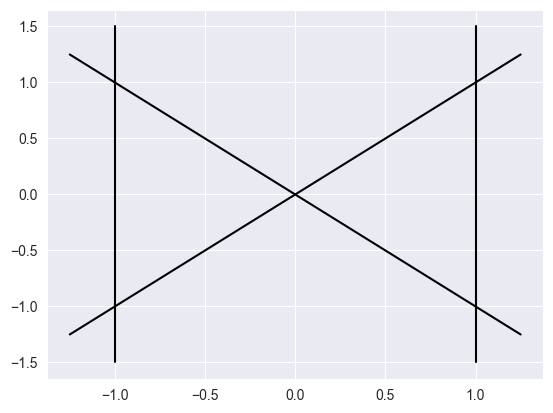

In [8]:
def plot_bowtie() -> None:
    plt.plot((1.25,-1.25),(1.25,-1.25),'k')
    plt.plot((1.25,-1.25),(-1.25,1.25),'k')
    plt.plot((-1,-1),(-1.5,1.5),'k')
    plt.plot((1,1),(-1.5,1.5),'k')

plot_bowtie()
plt.show()

The following functions visualizes the decision boundary of a neuron with sigmoid
activation, $y=\sigma(a+bx_1+cx_2)$. You can use it to help you find the right
values for the weights.

In [9]:
# Self practise
data[:10] * torch.tensor([-1, -3, 1], dtype=torch.float)

tensor([[-1.0000,  6.0000, -2.0000],
        [-1.0000,  6.0000, -1.9184],
        [-1.0000,  6.0000, -1.8367],
        [-1.0000,  6.0000, -1.7551],
        [-1.0000,  6.0000, -1.6735],
        [-1.0000,  6.0000, -1.5918],
        [-1.0000,  6.0000, -1.5102],
        [-1.0000,  6.0000, -1.4286],
        [-1.0000,  6.0000, -1.3469],
        [-1.0000,  6.0000, -1.2653]])

In [10]:
# Self practise
data[:10] @ torch.tensor([-1, -3, 1], dtype=torch.float)

tensor([3.0000, 3.0816, 3.1633, 3.2449, 3.3265, 3.4082, 3.4898, 3.5714, 3.6531,
        3.7347])

In [11]:
data[:10]

tensor([[ 1.0000, -2.0000, -2.0000],
        [ 1.0000, -2.0000, -1.9184],
        [ 1.0000, -2.0000, -1.8367],
        [ 1.0000, -2.0000, -1.7551],
        [ 1.0000, -2.0000, -1.6735],
        [ 1.0000, -2.0000, -1.5918],
        [ 1.0000, -2.0000, -1.5102],
        [ 1.0000, -2.0000, -1.4286],
        [ 1.0000, -2.0000, -1.3469],
        [ 1.0000, -2.0000, -1.2653]])

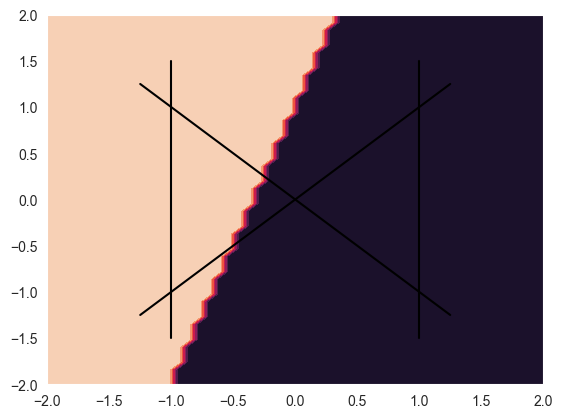

In [12]:
def plot_decision_boundary(grid_x: Tensor, grid_y, pred: Tensor) -> None:
  """Plot the estimated decision boundary for a 2D grid with predictions."""
  plot_bowtie()
  plt.contourf(grid_x, grid_y, pred.view(grid_x.shape))
  plt.show()

def activation(x: Tensor) -> Tensor:
  return torch.where(x > 0, 1., 0.)

def plot_decision_boundary_first_hidden(a: int, b: int, c: int) -> None:
  """Take 3 weights for one input neuron and plot resulting decision boundary.
  ,→"""
  neuron_output = (
  activation(data @ torch.tensor([a, b, c], dtype=torch.float))
  )
  plot_decision_boundary(grid_x, grid_y, neuron_output)
plot_decision_boundary_first_hidden(-1, -3, 1)

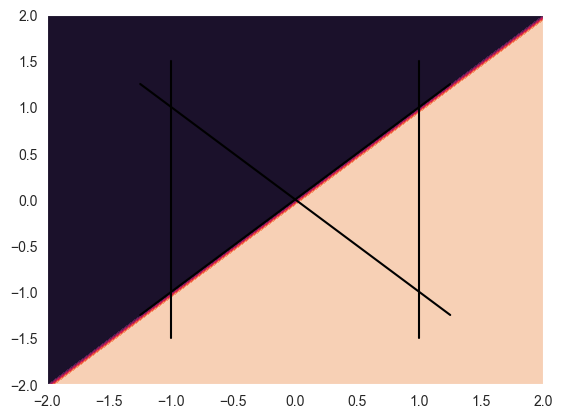

In [13]:
plot_decision_boundary_first_hidden(0, 1, -1)

For convenience, we group the parameters of the four neurons into a matrix with three
rows and five columns (one is for the bias), so that their output can be computed in a
single matrix multiplication. Each column contains the weights of a different neuron.
The first column contains a "fake" hidden neuron for the bias, whose value is always
one. Note that the first row of the weight matrix is connected to the bias of the
previous layer.

In [75]:

weights_1 = torch.tensor([
    [1, 0, 0], # bias neuron connected to the bias of the inputs
    [1, -1, 0],
    [1, 1, 0],
    [0, 1, -1],
    [0, 1, 1],
], dtype=torch.float).T
# Note: The weight matrix is transposed in the end. (5 x 3 --> 3 x 5)
# This gives more readability when entering your weights manually.

print(weights_1.shape)

torch.Size([3, 5])


Let us plot the predictions of the four neurons:

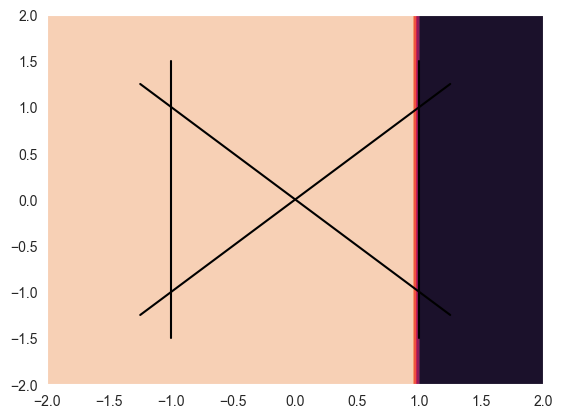

In [76]:
plot_decision_boundary_first_hidden(*weights_1[:, 1])

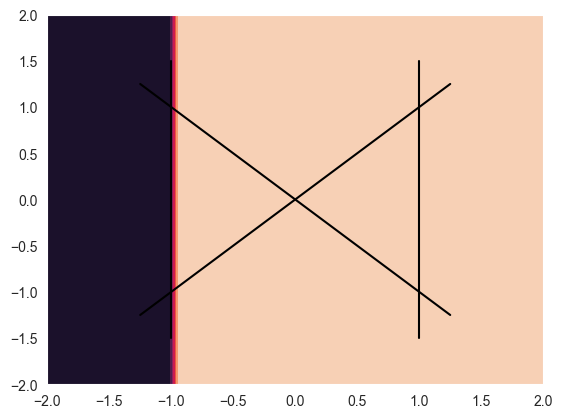

In [77]:
plot_decision_boundary_first_hidden(*weights_1[:, 2])

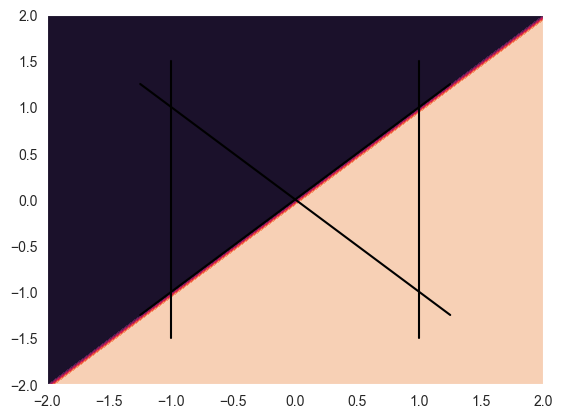

In [78]:
plot_decision_boundary_first_hidden(*weights_1[:, 3])

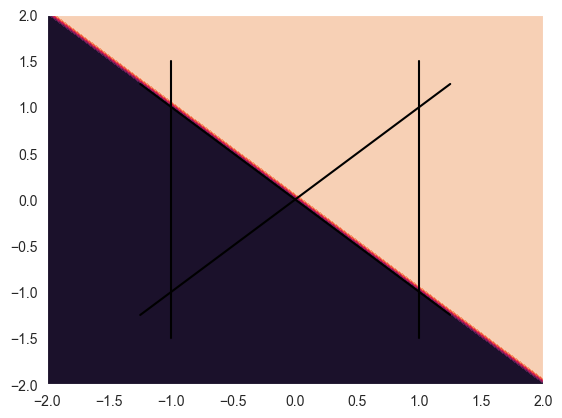

In [79]:
plot_decision_boundary_first_hidden(*weights_1[:, 4])

And this is the first hidden layer of the network. Let us compute its predictions for
each point of the grid:

In [89]:

hidden_1 = (
activation(data @ weights_1)
)

# Make sure that the number of rows is not changed,
print(len(hidden_1) == len(data))

# that there are five columns,
print(hidden_1.shape[1] == 5)

# and that the values are between zero and one
print(float(torch.min(hidden_1)), float(torch.max(hidden_1)))

True
True
0.0 1.0


In [90]:
hidden_1

tensor([[1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        ...,
        [1., 0., 1., 1., 1.],
        [1., 0., 1., 1., 1.],
        [1., 0., 1., 0., 1.]])

### Second hidden layer
The second hidden layer is composed of two neurons, each activating for inputs inside
one of the two triangles that make up our figure. These two neurons are connected to the
four neurons of the previous layer, thus each of them has five parameters.

Let us first create a new function to visualize the decision boundary of these
neurons in the second hidden layer.

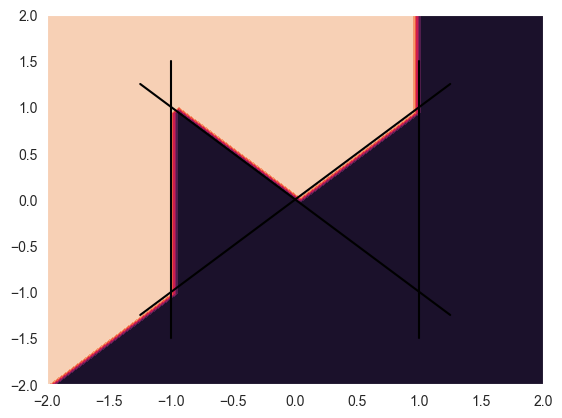

In [91]:
def plot_decision_boundary_second_hidden (
        a: int, b: int, c: int, d: int, e: int) -> None:
    """Take 5 weights for one hidden neuron and plot resulting decision boundary."""
    neuron_output = (
    activation(hidden_1 @ torch.tensor([a, b, c, d, e], dtype=torch.float))
# (The input is the result from the first layer)
    )
    plot_decision_boundary(grid_x, grid_y, neuron_output)

plot_decision_boundary_second_hidden(-2, 3, -1, -3, 1)

Now, as before, find the coefficients for the two neurons and put them into a matrix
with five rows and three columns. You can use the previous function to help you find
these weights.

**Hint:** You can think of these neurons as performing a logical AND operation on the
outputs of the neurons of the previous layer. All points inside each triangle must be
on the same side of three decision boundaries.

In [98]:

weights_2 = torch.tensor([
    [1, 0, 0, 0, 0],   # bias neuron connected to the bias of the inputs
    [-2, 1, 0, 1, 1],
    [-1, 1, 1, -1, -1]
], dtype=torch.float).T
# Note: The weight matrix is transposed in the end. (3 x 5 --> 5 x 3)
# This gives more readability when entering your weights manually.

print(weights_2.shape)

torch.Size([5, 3])


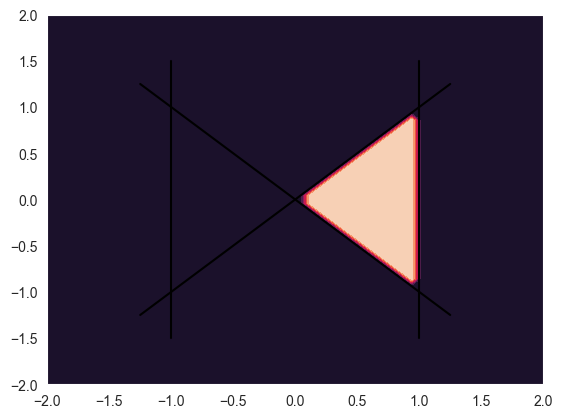

In [99]:
plot_decision_boundary_second_hidden(*weights_2[:, 1])

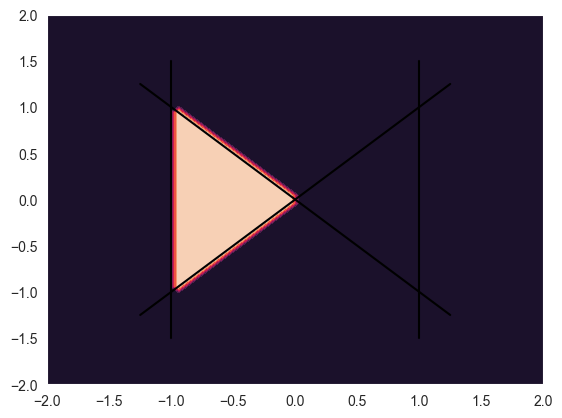

In [100]:
plot_decision_boundary_second_hidden(*weights_2[:, 2])

In [101]:

hidden_2 = (
activation(hidden_1 @ weights_2)
)

# Make sure that the number of rows is not changed,
print(len(hidden_2) == len(data))

# that there are five columns,
print(hidden_2.shape[1] == 3)

# and that the values are between zero and one
print(float(torch.min(hidden_2)), float(torch.max(hidden_2)))

True
True
0.0 1.0


In [103]:
hidden_1

tensor([[1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        ...,
        [1., 0., 1., 1., 1.],
        [1., 0., 1., 1., 1.],
        [1., 0., 1., 0., 1.]])

In [102]:
hidden_2

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])

### Output layer
Finally, we can seek the parameters for the output neuron.
It should activate when an input is inside either one of the two triangles.

**Hint:** You can think of the output neuron as performing a logical OR operation on
the outputs of the second hidden layer.

Let us again modify the visualization function to show the decision of the network:

In [104]:
def plot_decision_boundary_output (a: int, b: int, c: int) -> None:
    """Take 3 weights for one output neuron and plot resulting decision boundary."""
    neuron_output = (
        hidden_2 @ torch.tensor([a, b, c], dtype=torch.float)
# (The input is the result from the second layer)
    )
    plot_decision_boundary(grid_x, grid_y, neuron_output)

Now fill in the parameters:

In [113]:

weights_3 = torch.tensor([
    1,1,1
], dtype=torch.float)

print(weights_3.shape)

torch.Size([3])


The output of the neural network is:


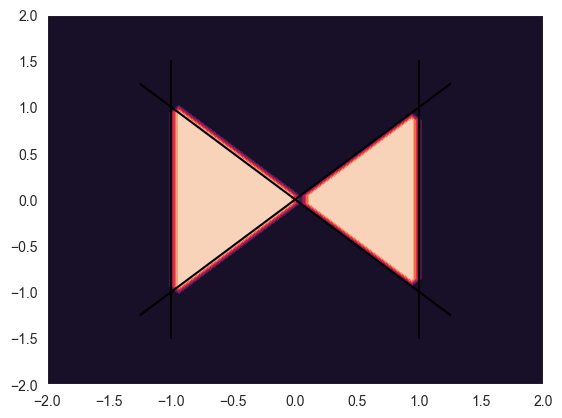

In [114]:
plot_decision_boundary_output(*weights_3)

Let us recap how the output is computed:

In [115]:
hidden_1 = activation(data @ weights_1)
hidden_2 = activation(hidden_1 @ weights_2)
output = hidden_2 @ weights_3

This is, in essence, the *forward pass*.

If you did everything correctly, you should see below the bow tie image we wanted to reproduce:

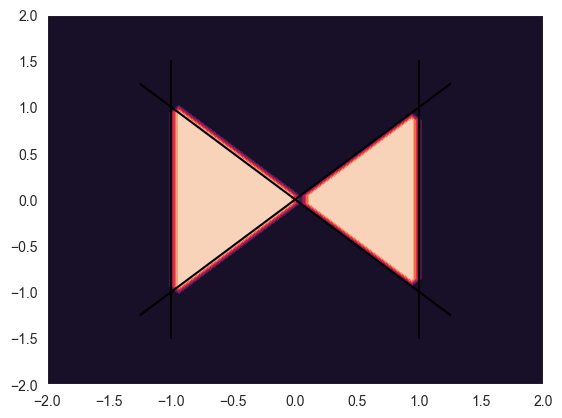

In [116]:
plot_decision_boundary(grid_x, grid_y, output)

## Exercise 3

**Note:** Focus on solving the second exercise first, as this exercise is of secondary
importance. Essentially, it shows that the same function can be computed by
many different neural networks.

Consider a neuron with incoming weights $\textbf{w}=w_1,\ldots,w_n$ bias $b$, and
activation $\tau(\cdot)$. This neuron is connected to the $i$-th neuron of the next
layer with the weight $v_i$, and the bias of the latter neuron is $c_i$. We want to
replace $\textbf{w}$, $v_i$, $b$ and $c_i$ with new parameters $\textbf{w}'$, $v'_i$,
$b'$ and $c'_i$ so that the output of the network is unchanged for all inputs.
At least one of the new parameters must be different, but some are allowed to equal
the old ones.

 1. Suppose that $\tau$ is the hyperbolic tangent. Show that the network computes the
same function if we let $\textbf{w}'=-\textbf{w}$, $v'_i=-v_i$, $b'=-b$ and $c'_i=c_i$.
 2. Now suppose that $\tau$ is the logistic sigmoid function. How should you set
$\textbf{w}'$, $v'_i$, $b'$ and $c'_i$? Hint: first, find the relationship between
$\sigma(x)$ and $\sigma(-x)$.
 3. Can you find other ways of modifying the parameters of a neural network without
altering its output? Equivalently, given a neural network computing a certain function,
how can you find a different network that computes the same function?

You do not have to provide a formal answer, but you can do so if you wish.
